# `StableSpectralElements.jl` - 3D linear advection example

First, let's load the required packages.

In [62]:
using StableSpectralElements, OrdinaryDiffEq
using Plots, Plots.PlotMeasures, Printf, TimerOutputs, BenchmarkTools

We will solve the three-dimensional linear advection equation
$$
\partial_t U(\boldsymbol{x},t) + \nabla_{\boldsymbol{x}} \cdot (\boldsymbol{a} U(\boldsymbol{x},t)) = 0,  \quad \forall\, (\boldsymbol{x}, t) \in \Omega \times (0,T),
$$
with $a = [1,1,1]^{\mathrm{T}}$ and $\Omega = (0,L)^3$, where we take $L = 1$, and $T = 1$, and impose periodic boundary conditions as well as the initial condition
$$
U(\boldsymbol{x},0) = \cos(2\pi x_1 / L)\cos(2\pi x_2 / L)\cos(2\pi x_3 / L), \quad \forall \, \boldsymbol{x} \in \Omega.
$$

In [63]:
a = (1.0,1.0,1.0)  # advection velocity
L = 1.0  # domain length
T = 1.0  # end time

conservation_law = LinearAdvectionEquation(a)
exact_solution = InitialDataCosine(1.0,(2π/L, 2π/L, 2π/L));

We'll discretize the above problem using a `ModalTensor` discretization of degree $p = 7$, on a curved (i.e. using a mapping of degree $p_{\mathrm{map}} = 3$) tetrahedral mesh with $M = 2$ edges in each direction. A skew-symmetric split form will be used to treat the curvilinear coordinate transformation in a provably stable manner, and we will use an upwind (i.e. Lax-Friedrichs) numerical flux.

In [64]:
M = 2
p = 7

reference_approximation = ReferenceApproximation(
    ModalTensor(p), Tet(), mapping_degree=3)

form = StandardForm(mapping_form=SkewSymmetricMapping(), 
    inviscid_numerical_flux=LaxFriedrichsNumericalFlux())

uniform_mesh = uniform_periodic_mesh(reference_approximation,
    ((0.0,L),(0.0,L),(0.0,L)), (M,M,M))

mesh = warp_mesh(uniform_mesh, reference_approximation, 0.1, L) 

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation, project_jacobian=true)

results_path = save_project(conservation_law,
     spatial_discretization, exact_solution, form, (0.0, T),
     "results/advection_3d/", overwrite=true, clear=true);

We will now plot the reference element, with the volume quadrature nodes shown on the left and the facet quadrature nodes shown on the right.

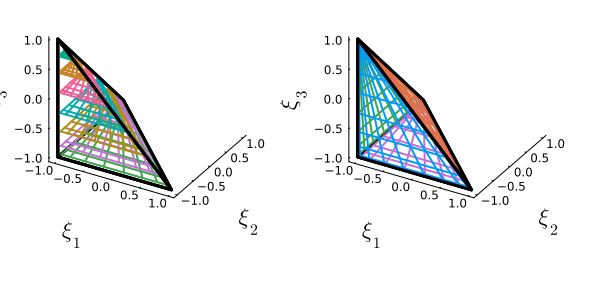

In [65]:
vol_quad_plot = plot(reference_approximation, volume_connect=true, 
    facet_quadrature=false, fmt=:png, size=(300,300))
fac_quad_plot = plot(reference_approximation, facet_connect=true, 
    volume_quadrature=false, fmt=:png, size=(300,300), facet_inds=[3,4,1,2])
plot(vol_quad_plot,fac_quad_plot,size=(600,300),margin=5mm, fmt=:png)

The mesh is shown below.

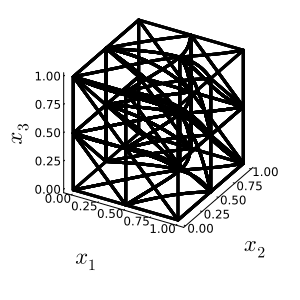

In [66]:
plot(spatial_discretization, volume_quadrature=false, facet_quadrature=false, fmt=:png, size=(300,300))

Using the `semidiscretize` function, we can create an `ODEProblem` object for use with OrdinaryDiffEq.jl's `solve` function. Here we've chosen the option for a weight-adjusted approximation of the mass matrix inverse from [Chan et al. (SISC 2017)](https://arxiv.org/abs/1608.03836), which allows for modal schemes to be applied efficiently at high order with explicit time-marching methods.

In [67]:
CFL = 0.4
h = L/(reference_approximation.N_p * spatial_discretization.N_e)^(1/3)
dt = CFL * h / sqrt(a[1]^2 + a[2]^2 + a[3]^2)

ode_problem = semidiscretize(conservation_law, spatial_discretization,
    exact_solution, form, (0.0, T));

In [68]:
reset_timer!()
sol = solve(ode_problem, CarpenterKennedy2N54(), adaptive=false, dt=dt,
    save_everystep=false, 
    callback=save_callback(results_path, (0.0,T), floor(Int, T/(dt*50))))
print_timer()

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            5.88s /  98.2%           4.28GiB /  99.8%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 semi-disc. residual      470    5.77s  100.0%  12.3ms   4.27GiB  100.0%  9.30MiB
   time deriv.          22.6k    4.76s   82.5%   211μs   3.97GiB   93.0%   184KiB
   nodal values         22.6k    939ms   16.3%  41.6μs    307MiB    7.0%  13.9KiB
 ────────────────────────────────────────────────────────────────────────────────


We can then compute the $L^2$ norm of the solution error using the scheme's volume quadrature rule.

In [69]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
println("L2 error:")
println(analyze(error_analysis, last(sol.u), exact_solution, T)...)

L2 error:
0.005236447527330425


The conservation and energy dissipation properties of the scheme are verified as follows.

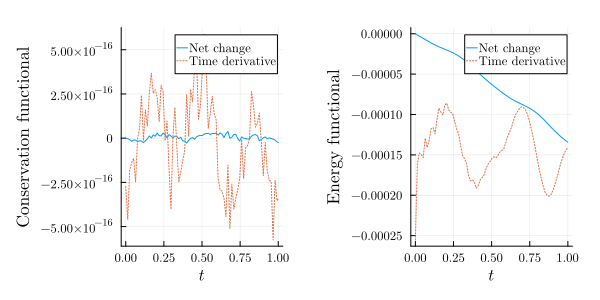

In [70]:
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
p1 = plot(analyze(conservation_analysis, load_time_steps(results_path)), 
    ylabel="Conservation functional",)
p2 = plot(analyze(energy_analysis, load_time_steps(results_path)), 
    ylabel="Energy functional")
plot(p1,p2, size=(600,300),margin=5mm, fmt=:png)

We can now postprocess the solution for visualization, producing a `.vtu` file.

In [71]:
postprocess_vtk(spatial_discretization,
    string(results_path,"solution.vtu"), last(sol.u));